In [1]:
from __future__ import division
from __future__ import print_function

import numpy as np
np.random.seed(1337) # for reproductivity

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import six
import keras
from keras.models import Sequential, Model
from keras.layers import Input, merge # Merge is a layer, used to merge layers, merge is for tensors
from keras.layers.core import Layer, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import ZeroPadding2D, AveragePooling2D, MaxPooling2D, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [2]:
def _bn_relu(input):
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation('relu')(norm)

def _conv_bn_relu(**conv_params): #conv_params is a dictionary
    nb_filter = conv_params["nb_filter"]
    kernel_size = conv_params.setdefault("kernel_size", (3, 3))
    stride = conv_params.setdefault("stride", (1,1)) #default is identity mapping, no strides
    kernel_init = conv_params.setdefault("kernel_init", "he_normal")
    padding = conv_params.setdefault("padding","same")
    
    def f(input):
        conv = Convolution2D(filters=nb_filter, kernel_size=kernel_size, strides=stride, padding=padding,
                             kernel_initializer=kernel_init)(input)
        return _bn_relu(conv)
    return f

def _bn_relu_conv(**conv_params):
    nb_filter = conv_params["nb_filter"]
    kernel_size = conv_params.setdefault("kernel_size", (3, 3))
    stride = conv_params.setdefault("stride", (1,1)) #default is identity mapping, no strides
    kernel_init = conv_params.setdefault("kernel_init", "he_normal")
    padding = conv_params.setdefault("padding","same")
    
    def f(input):
        activation = _bn_relu(input)
        return Convolution2D(filters=nb_filter, kernel_size=kernel_size, strides=stride, padding=padding,
                             kernel_initializer=kernel_init)(activation)
    return f


def _shortcut(input, residual):
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]
    
    shortcut=input
    if stride_width>1 or stride_height>1 or not equal_channels: #downsampling or increasing feature numbers
        shortcut = Convolution2D(residual_shape[CHANNEL_AXIS], (1, 1), kernel_initializer="he_normal",
                                 strides=(stride_width, stride_height))(input)
        
    return merge([shortcut, residual], mode="sum")


def basic_block(nb_filter, subsample=(1,1), is_first_block_of_first_layer=False):
    def f(input):
        if is_first_block_of_first_layer:
            conv1 = Convolution2D(filters=nb_filter, kernel_size=(3, 3), padding='same', strides=subsample)(input)
        else:
            conv1 = _bn_relu_conv(nb_filter=nb_filter, kernel_size=(3,3), padding='same', strides=subsample)(input)
        
        residual = _bn_relu_conv(nb_filter=nb_filter, kernel_size=(3,3), padding='same', strides=subsample)(conv1)
        
        """
        residual = Convolution2D(filters=nb_filter, (3,3), padding='same', strides=init_subsample)(conv1)
        """
        
        return _shortcut(input, residual)
    return f


def _residual_block(block_function, nb_filter, repetitions, is_first_layer=False): # first layer requires input shape
    def f(input):
        for i in range(repetitions):
            init_subsample = (1, 1)
            if i == repetitions - 1 and not is_first_layer: # last conv in the block will downsample
                init_subsample = (2, 2)
            input = block_function(nb_filter=nb_filter, subsample=init_subsample, 
                                   is_first_block_of_first_layer=(is_first_layer and i==0))(input)
                                   # first block of first layer will require input shape
        return input
    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf': #use tensorflow as backend
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:  # 'th' use theano as backend
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3

def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier
    
class ResNetBuilder(object):
    @staticmethod
    def build(input_shape, block_fn, repetitions):
        _handle_dim_ordering() #decide backend and image shape ordering
        
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple(nb_rows, nb_cols, nb_channels)")
        
        if K.image_dim_ordering() == 'tf':
            input_shape = input_shape
            
        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(nb_filter=24, kernel_size=(6, 6))(input)
        pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv1)
        
        block = pool1
        
        #now start the residual block part
        Filters= [24, 32, 64, 96, 128]
        nb_filter = Filters[0]
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, nb_filter=nb_filter, repetitions=r, is_first_layer=(i==0))(block)
            nb_filter=Filters[i+1]
        
        #fully connect part
        block = _bn_relu(block)
        flatten = Flatten()(block)
        dense1 = Dense(100, kernel_initializer='he_normal', activation='relu')(flatten)
        dense2 = Dense(10, kernel_initializer='he_normal', activation='relu')(dense1)
        dense3 = Dense(1, kernel_initializer='he_normal', activation='linear')(dense2)
        
        model = Model(input=input, output=dense3)
        return model
    
    @staticmethod
    def build_resnet_basic(input_shape):
        return ResNetBuilder.build(input_shape, basic_block, [2,2,2,2])

In [3]:
if __name__ == '__main__':
    import scipy.io as sio
    from keras.callbacks import EarlyStopping
    early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
    
    batch_size = 40
    nb_epoch = 100
    img_rows, img_cols = 128, 128
    img_channels = 1
    
    WB = sio.loadmat('sandstone_data.mat')['Data']
    Y_data = sio.loadmat('sandstone_data.mat')['L']
    Y_data = (Y_data - min(Y_data))/(max(Y_data) - min(Y_data))  # normalization
    X_data = np.reshape(WB, (768, img_channels, img_rows, img_cols))
    X_train = X_data[0:720]
    X_val = X_data[720:768]
    Y_train = Y_data[0:720]
    Y_val = Y_data[720:768]
    
    WB1 = sio.loadmat('test_sandstone_data.mat')['Data']
    X_test = np.reshape(WB1, (240, 1, img_rows, img_cols))
    Y_test = sio.loadmat('test_sandstone_data.mat')['L']
    Y_test = (Y_test-min(Y_test))/(max(Y_test) - min(Y_test))


    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_test = X_test.astype('float32')
    
    model = ResNetBuilder.build_resnet_basic((img_rows, img_cols, img_channels))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_val, Y_val)) 
              #callbacks=early_stopper)

/home/conebeam/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/conebeam/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/conebeam/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:130: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Train on 720 samples, validate on 48 samples
Epoch 1/100
720/720 [==============================] - 245s - loss: 2930.5850 - mean_absolute_error: 16.0931 - val_loss: 16.5342 - val_mean_absolute_error: 3.6639
Epoch 2/100
720/720 [==============================] - 257s - loss: 0.0732 - mean_absolute_error: 0.2179 - val_loss: 0.1187 - val_mean_absolute_error: 0.3303
Epoch 3/100
720/720 [==============================] - 257s - loss: 0.0363 - mean_absolute_error: 0.1515 - val_loss: 0.0294 - val_mean_absolute_error: 0.1514
Epoch 4/100
720/720 [==============================] - 254s - loss: 0.0255 - mean_absolute_error: 0.1328 - val_loss: 0.0098 - val_mean_absolute_error: 0.0814
Epoch 5/100
720/720 [==============================] - 267s - loss: 0.0223 - mean_absolute_error: 0.1238 - val_loss: 0.0171 - val_mean_absolute_error: 0.1041
Epoch 6/100
720/720 [==============================] - 253s - loss: 0.0187 - mean_absolute_error: 0.1130 - val_loss: 0.0167 - val_mean_absolute_error: 0.1023
Ep

720/720 [==============================] - 264s - loss: 0.0013 - mean_absolute_error: 0.0278 - val_loss: 7.2191e-04 - val_mean_absolute_error: 0.0208
Epoch 53/100
720/720 [==============================] - 259s - loss: 0.0012 - mean_absolute_error: 0.0266 - val_loss: 0.0014 - val_mean_absolute_error: 0.0301
Epoch 54/100
 80/720 [==>...........................] - ETA: 250s - loss: 6.3426e-04 - mean_absolute_error: 0.0193

KeyboardInterrupt: 

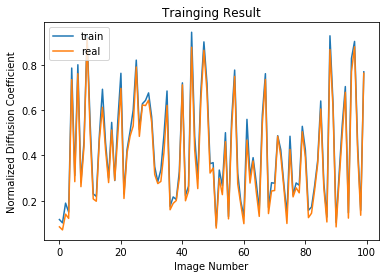

In [5]:
x=[]
for i in range(100):
    x.append(i)

pred=model.predict(X_train)

fig = plt.figure()
ax=fig.add_subplot(1,1,1)

ax.plot(x,pred[:100], label='train')
ax.plot(x,Y_train[:100],label='real')
plt.legend()
ax.set_title('Trainging Result')
ax.set_xlabel('Image Number')
ax.set_ylabel('Normalized Diffusion Coefficient')

0.0217506059821


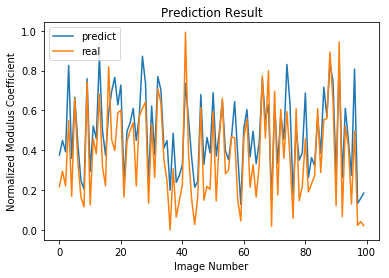

In [6]:
x=[]
for i in range(100):
    x.append(i)

pred=model.predict(X_test)
print(mean_squared_error(Y_test, pred))

fig1 = plt.figure()
ax1=fig1.add_subplot(1,1,1)

ax1.plot(x,pred[0:100], label='predict')
ax1.plot(x,Y_test[0:100],label='real')
plt.legend()
ax1.set_title('Prediction Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')